# Visualize waveforms, CC, maps

Repeater clusters: Kmeans clusters that have at least one repeater earthquake in it

Forced k = 2000, made wee clusters around the repeater events so we're looking at those clusters

* Plot repeater waveforms and waveforms in repeater clusters (time lagged, normalized, filtered 2-30Hz)

* Plot CC matrix for Repeater cluster

* Plot maps by cluster


# Takeaways

* additional repeater earthquake discovered
* possibly a different REQS discovered
* many of the clusters have similar waveforms, but not always similar to the repeating cluster
* put another way, found other repeating clusters in the catalog
* Next steps :: instead of Kmeans clusters, just take the fingerprints that are within XX-distance in FP-L2 distance; find more similar clusters

### 


===============================================================

Todo::

* look at spectra, ACM, FPS for repeater clusters, headed by the repeater in that cluster



In [1]:

import numpy as np
import h5py
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import sys
sys.path.append('../src/data/')
sys.path.append('src/')

sys.path.append('/Users/theresasawi/Documents/12_Projects/specufex_processing/3_post/1_clustering/functions/')
# sys.path.append('/Users/theresasawi/Documents/11_Manuscripts/Sawietal_2021/SawiEtAl_2021/src/visualization/')

from importlib import reload
import functions_clustering as funclust
reload(funclust)


# from functions2 import linearizeFP, PCAonFP, PVEofPCA, getTopFCat

from notebook_functions import linearizeFP, PVEofPCA, getTopFCat, findKmeansKopt,selectKmeans,plotPCA,getWF, calcCCMatrix
from notebook_functions import calcCorr_template, lagWF_Scalar, lagWF

import yaml

import argparse

from matplotlib import cm

from obspy.signal.cross_correlation import correlate, xcorr_max

# plt.rcParams['image.cmap']='magma'

# plt.rcParams.update({'font.size': 8})

# cmap=cm.get_cmap('rainbow')


# colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))





### Load config yaml file

In [2]:
yamlPath = "/Users/theresasawi/Documents/12_Projects/sareq_sawietal/SAREQ_00.yaml"

with open(yamlPath) as stream:
    config = yaml.safe_load(stream)

## Set paths, variables

In [3]:

# pull out config values for conciseness
path_config = config["paths"]
key = path_config["key"]

data_config = config['dataParams']
station = data_config["station"]
channel = data_config["channel"]
channel_ID = data_config["channel_ID"]
sampling_rate = data_config["sampling_rate"]

sgram_config = config["sgramParams"]
nfft = sgram_config["nfft"]
fmin, fmax = sgram_config["fmin"], sgram_config["fmax"]




# build path strings
dataH5_name = f'data_{key}.h5'
projectPath = path_config["projectPath"]
pathWF = path_config["pathWF"]

dataH5_name =  'data_' + path_config["h5name"] #f'data_{key}.hdf5'
dataH5_path = projectPath + 'data/H5files/' + dataH5_name

SpecUFEx_H5_name = 'SpecUFEx_' + path_config["h5name"] #f'SpecUFEx_{key}.hdf5'
SpecUFEx_H5_path = projectPath + 'data/H5files/' + SpecUFEx_H5_name
pathWf_cat  = projectPath + 'wf_cat_out.csv'
sgramMatOut = projectPath + 'matSgrams/'## for testing

# pathSgram_cat = projectPath + f'sgram_cat_out_{key}.csv'
pathSgram_cat = projectPath + f'sgram_cat_out_{key}.csv'

path_Data = projectPath + 'data/processed/'

sgram_cat = pd.read_csv(pathSgram_cat)


## spectrogram parameters

In [4]:



with h5py.File(SpecUFEx_H5_path,'a')as specH5:
    tSTFT = specH5['spec_parameters/tSTFT'][:]
    fSTFT = specH5['spec_parameters/fSTFT'][:]    

### Plotting specs for JGR

In [5]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

## Load clustererd PCA catalogs 
### We chose K= 15 and K=1000 in the previous notebook

In [6]:

PCA_df15 = pd.read_csv(f"{path_Data}/clusterCat_K15.csv")
cat_repeater15 = pd.read_csv(f"{path_Data}/clusterCatRepeater_K15.csv")    

PCA_df1000 = pd.read_csv(f"{path_Data}/clusterCat_K1000.csv")
cat_repeater1000 = pd.read_csv(f"{path_Data}/clusterCatRepeater_K1000.csv")    

PCA_df2000 = pd.read_csv(f"{path_Data}/clusterCat_K2000.csv")
cat_repeater2000 = pd.read_csv(f"{path_Data}/clusterCatRepeater_K2000.csv")    

PCA_df15 = PCA_df15.drop(columns={"Unnamed: 0"})
cat_repeater15 = cat_repeater15.drop(columns={"Unnamed: 0"})
PCA_df1000 = PCA_df1000.drop(columns={"Unnamed: 0"})
cat_repeater1000 = cat_repeater1000.drop(columns={"Unnamed: 0"})
PCA_df2000 = PCA_df2000.drop(columns={"Unnamed: 0"})
cat_repeater2000 = cat_repeater2000.drop(columns={"Unnamed: 0"})


### For each of the repeater clusters in K=2000, we'll take the other waveforms in that cluster an plot them

In [41]:
catRep

,PC1,PC2,PC3,PC4,PC5,Cluster,SS,euc_dist,ev_ID,event_ID
0,-0.439537,-0.359281,0.134550,-0.257910,0.180053,1682,0.047937,19.689936,112576,112576
1,-0.299955,-0.511928,-0.012262,-0.236248,0.157787,227,-0.008268,20.058599,30068288,30068288
2,-0.470008,-0.304305,-0.047001,-0.269402,0.332401,542,0.035526,20.188960,21269282,21269282
3,-0.511152,-0.438605,0.054564,-0.340947,0.279520,1682,0.106600,19.908981,75019,75019
4,-0.481132,-0.132601,0.094467,-0.205538,0.045564,94,0.157488,19.411462,147374,147374
5,-0.512199,-0.203753,0.025965,-0.176135,0.100302,1203,0.210102,19.647378,51176842,51176842
6,-0.359181,-0.445558,-0.040052,-0.266508,-0.024194,227,-0.024475,19.639477,236562,236562
7,-0.327181,-0.251771,-0.074960,-0.101921,0.098626,89,-0.007215,19.975669,21434869,21434869
8,0.306252,-0.092309,-0.198638,-0.206066,-0.118228,1476,0.000000,19.238901,51212810,51212810
9,-0.448634,-0.238539,0.036025,-0.155914,0.086171,1203,-0.012114,19.526231,490792,490792


In [7]:
NN=2000
exec(f"catRep = cat_repeater{NN}")## 16 repeating events 
print(len(catRep))
repeater_clust = np.unique(catRep.Cluster)
Kopt = len(repeater_clust)


Kopt, repeater_clust ##unique clusters is Kopt

16


(9, array([  21,   89,   94,  187,  227,  542, 1203, 1476, 1682]))

In [8]:
print(fmin, fmax, sampling_rate)
print(dataH5_path,station,channel)

3 20 100
/Users/theresasawi/Documents/12_Projects/sareq_sawietal/data/H5files/data_SAREQ_00.h5 BAV EHZ


## These are JUST the repeaters, sorted by cluster

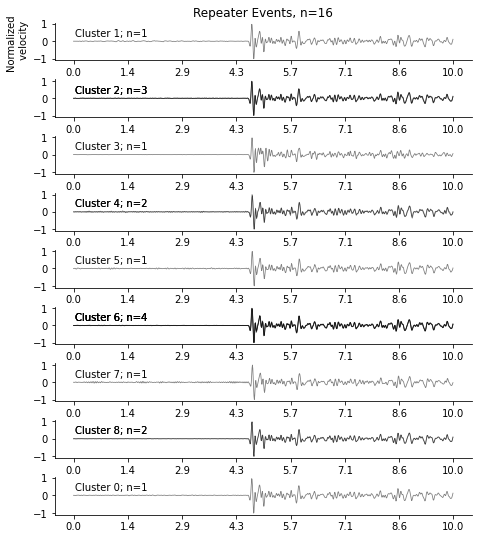

In [22]:
# plt.rcParams.update({'font.size': 8})

## mute depreciation warning
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)

template_index=0

gs = gridspec.GridSpec(Kopt,1)
gs.update(wspace=.5,hspace=.5)

tfont = 14
lw=.8
alpha=.5




for i, evID in enumerate(catRep.event_ID):    

        
        
    cluster = catRep.Cluster.iloc[i] #name of cluster
    k = np.argwhere(repeater_clust==cluster)[0][0] #index of cluster

    ax=plt.subplot(gs[k-1]);
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ### lag time to maximize CC coef
#     lag0 = lag_mat[(k-1)*5,:] ## get template for each cluster
    
    
    # load wf from H5
    wf = getWF(str(evID),dataH5_path,station,channel,fmin,fmax,sampling_rate)
    
    #Norm by max and zero mean
    wf_norm = wf / np.max(np.abs(wf))
    wf_zeromean = wf_norm - np.mean(wf_norm)
    
    offset = 0#.05
    wf_offset = (wf_zeromean) + i*offset#1.5
    
#     waveform_shift = lagWF(wf_offset, lag0, index_wf=i)
    ##plot !!

    plt.plot(wf_offset,lw=lw,alpha=alpha,c='k')
    

    if k==1:
        ax.set_ylabel('Normalized \n velocity')
    if k==Kopt:
        ax.set_xlabel('Time (s)')

#     if k!=Kopt:
#         ax.set_xlabel('')
#         ax.set_xticklabels('')        
#     else:
#         ax.set_xlabel('')
    

# #### General
    ticks=[c for c in np.linspace(0,len(wf_zeromean),8)]
    ticklabels=[f'{c:.1f}' for c in np.linspace(0,np.ceil(max(tSTFT)),8)]
    plt.xticks(ticks=ticks,labels=ticklabels)

    plt.text(3.3,0.3,f'Cluster {k}; n={len(catRep[catRep.Cluster==cluster])}')
    
    

ax=plt.subplot(gs[0])
ax.set_title(f"Repeater Events, n={len(catRep)}")
plt.savefig(f'figures/repeaterWaveforms_k{NN}.png')

## Same Figure, but with the other cluster members....

## make catalog of all events in the repeater clusters

In [10]:

exec(f"catAll = PCA_df{NN}")
catAll.sort_values(by="Cluster");


catAllClusAll = pd.DataFrame() #all events in repeater-clusters

p=0


for i, cluster in enumerate(repeater_clust):    

    
    lenClus = len(catAllClusAll) #for lag matrix
    
    catAllClus = catAll.where(catAll.Cluster==cluster).dropna() ## make subcatalogs by cluster
    catAllClusAll = catAllClusAll.append(catAllClus)


In [11]:
## Calculate cross correlation matrices and lag times


catAllClusAll['event_ID'] = [str(evv)[:-2] for evv in catAllClusAll.event_ID] #need to reformat evIDs
catAllClusAll['Cluster'] = [str(Cluster)[:-2] for Cluster in catAllClusAll.Cluster] #need to reformat cluster numbers


print(f'calculating CC...')


cc_mat,lag_mat = calcCCMatrix(catAllClusAll,len(catAllClusAll),dataH5_path,station,channel,fmin,fmax,sampling_rate)


np.save(f'{projectPath}data/processed/ccMat_k{NN}.npy',cc_mat)
np.save(f'{projectPath}data/processed/ccLagMat_k{NN}.npy',lag_mat)


calculating CC...


In [12]:
cc_mat.shape

(39, 39)

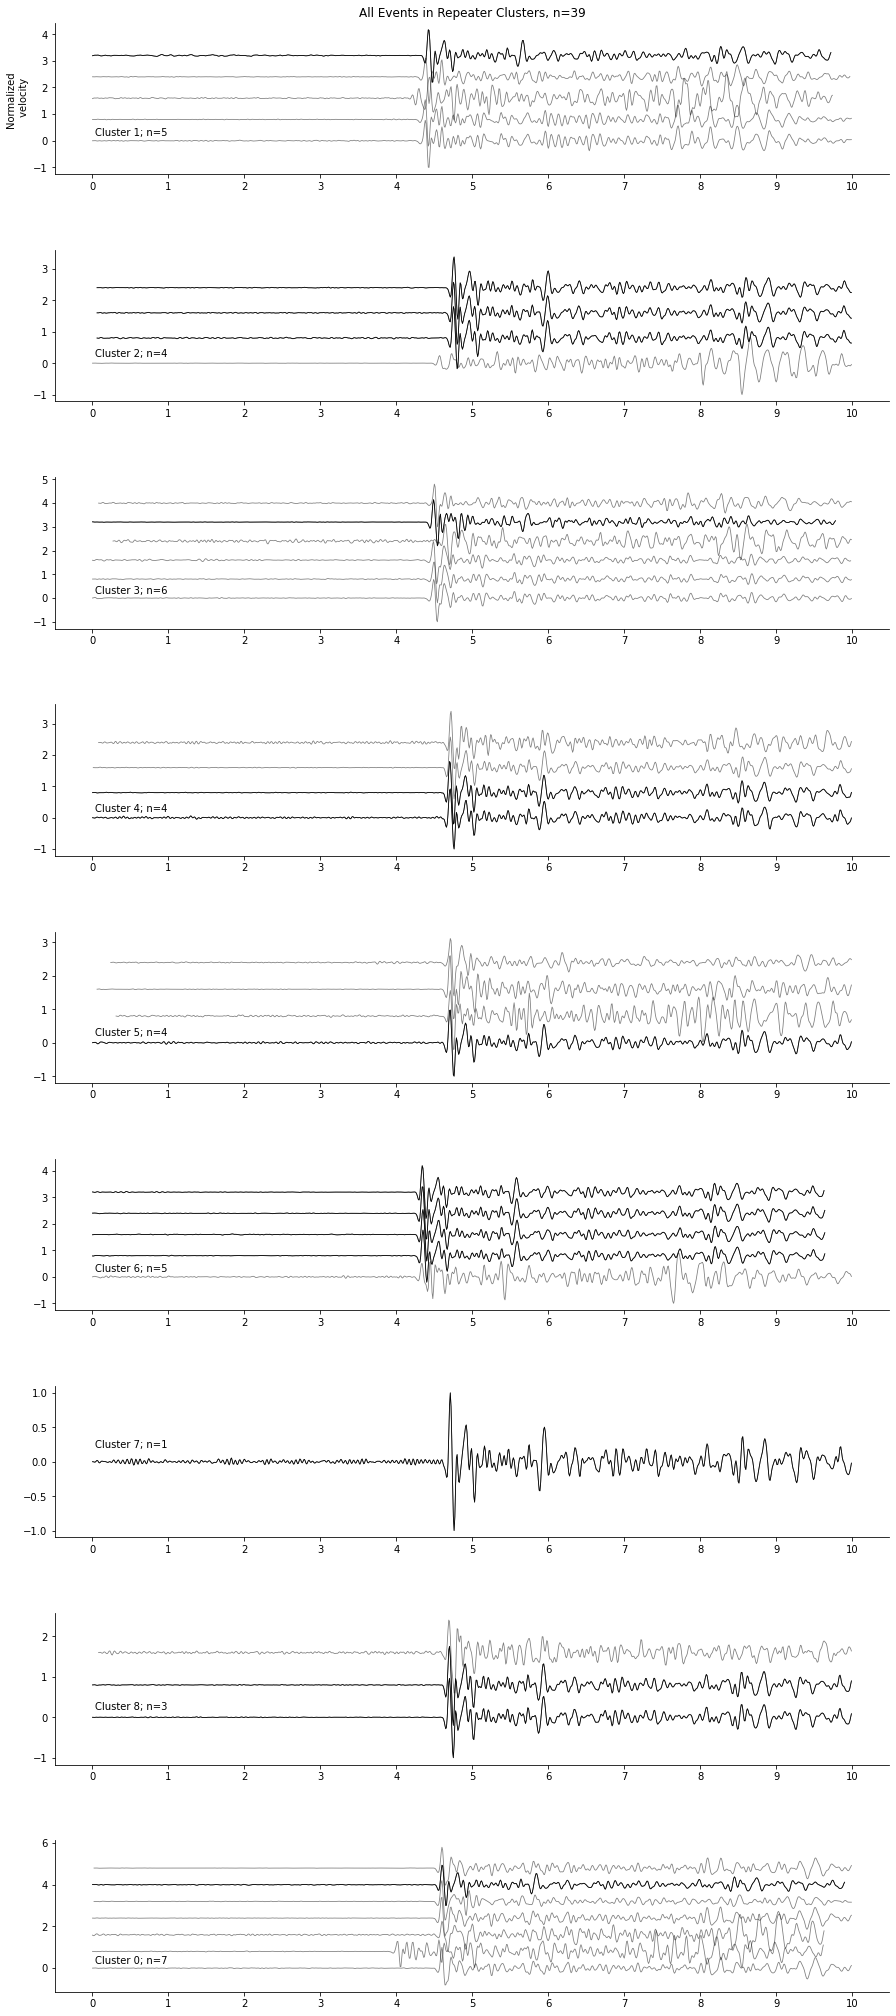

In [13]:
# plt.rcParams.update({'font.size': 8})
## mute depreciation warning
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


fig,axes = plt.subplots(figsize = (width2*2,height2*4))#,sharex=True)#,constrained_layout=True)
gs = gridspec.GridSpec(Kopt,1)
gs.update(wspace=.5,hspace=.5)



tfont = 14
lw=.8
alpha=.5



catAllClusAll = pd.DataFrame() #all events in repeater-clusters

p=0


for i, cluster in enumerate(repeater_clust):    

    
    lenClus = len(catAllClusAll) #for lag matrix
    
    catAllClus = catAll.where(catAll.Cluster==cluster).dropna() ## make subcatalogs by cluster
    catAllClusAll = catAllClusAll.append(catAllClus)

#     print('template index ', lenClus, 'len cluster ', len(catAllClus))
    
    k = int(np.argwhere(repeater_clust==cluster)[0][0]) #index of cluster

    lag0 = lag_mat[lenClus,:] ## get template for each cluster    
    
    ax=plt.subplot(gs[k-1]);

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ### lag time to maximize CC coef
#     lag0 = lag_mat[(k-1)*5,:] ## get template for each cluster

    for j, evID in enumerate(catAllClus.event_ID):
        # load wf from H5

#         print('wf index', p)
        wf = getWF(str(evID)[:-2],dataH5_path,station,channel,fmin,fmax,sampling_rate)

        #Norm by max and zero mean
        wf_norm = wf / np.max(np.abs(wf))
        wf_zeromean = wf_norm - np.mean(wf_norm)

        ## offset waveforms
        offset = 0.8#.05
        wf_offset = (wf_zeromean) + j*offset#1.5
        

        ##shift wf to maximize CC
        waveform_shift = lagWF(wf_offset, lag0, index_wf=p)        


        ##plot !!
        plt.plot(waveform_shift,lw=lw,alpha=alpha,c='k')

        
        
        if int(evID) in list(catRep.event_ID):## plot the actual, cataloged repeaters:
            plt.plot(waveform_shift,lw=lw,alpha=1,c='k')            


        if k==1:
            ax.set_ylabel('Normalized \n velocity')
        if k==Kopt:
            ax.set_xlabel('Time (s)')



        p +=1
        
        
    ticks=[c for c in np.linspace(0,len(wf_zeromean),11)]
    ticklabels=[f'{c:.0f}' for c in np.linspace(0,np.ceil(max(tSTFT)),11)]
    plt.xticks(ticks=ticks,labels=ticklabels)

    plt.text(3.3,0.2,f'Cluster {k}; n={len(catAllClus)}')
 


ax=plt.subplot(gs[0])
ax.set_title(f"All Events in Repeater Clusters, n={len(catAllClusAll)}")


plt.savefig(f'figures/Repeater_Clusters_timeshift_K{NN}.png')



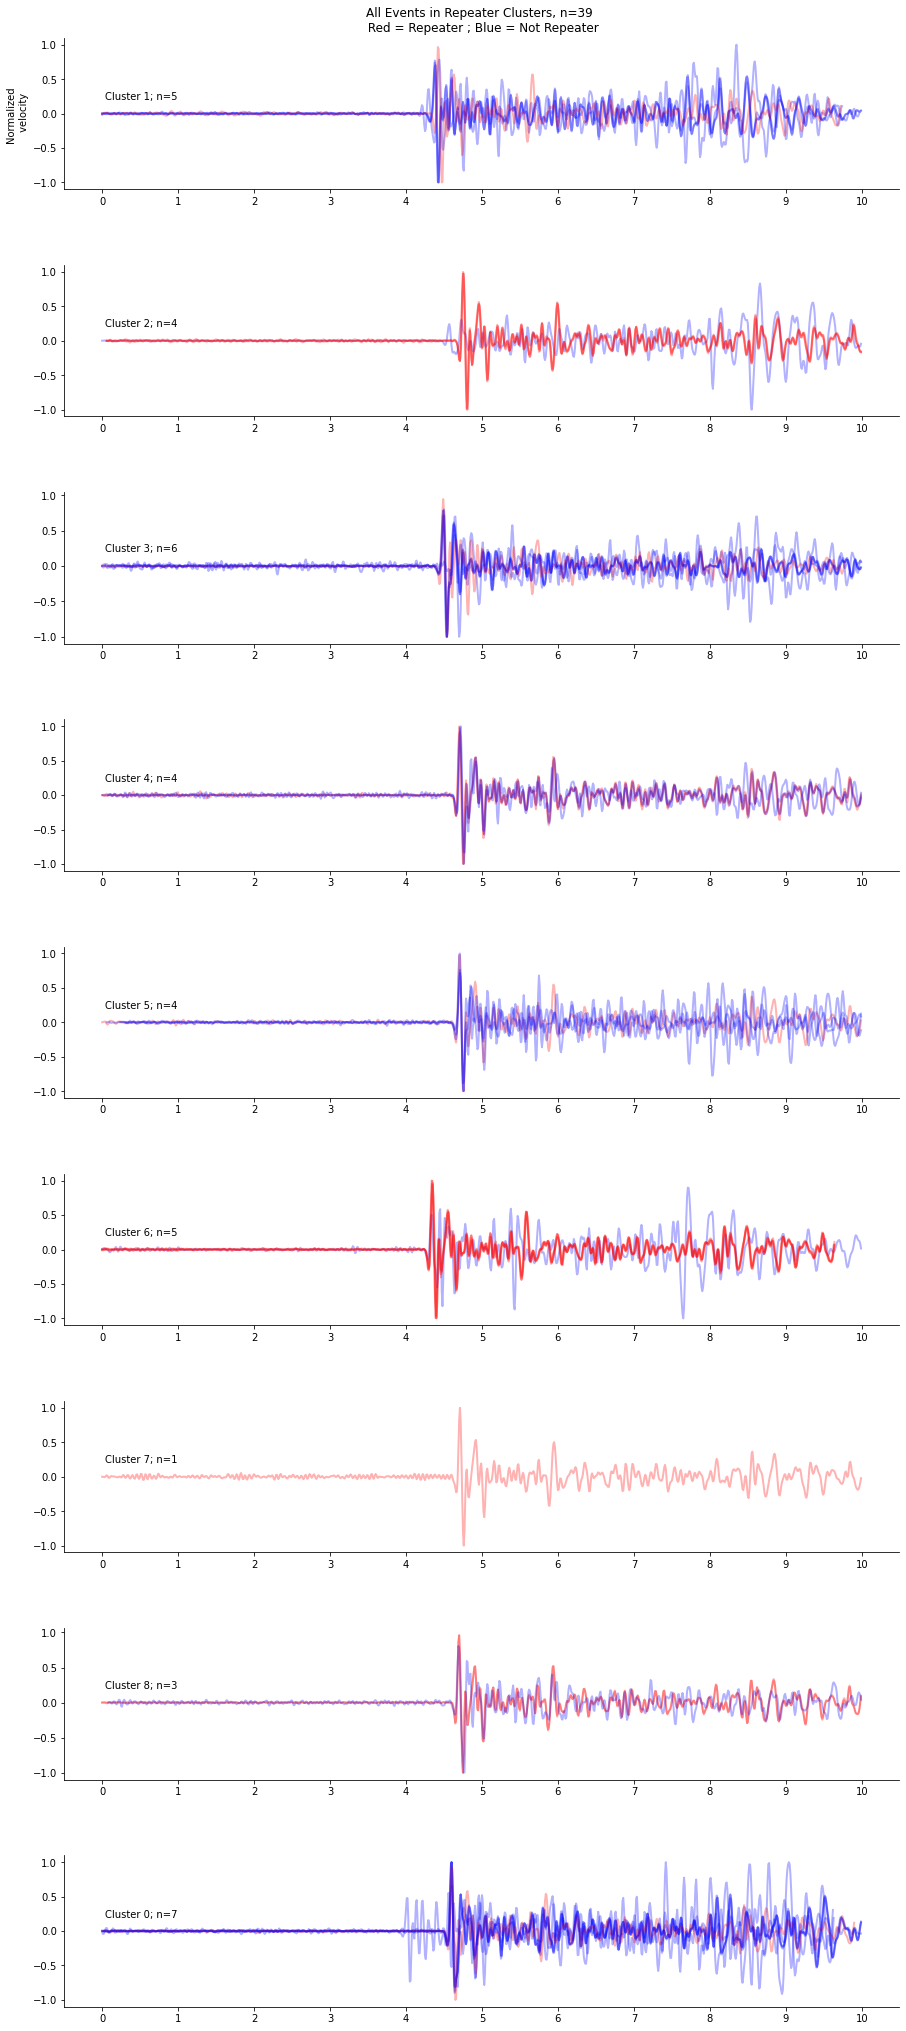

In [14]:
# plt.rcParams.update({'font.size': 8})
## mute depreciation warning
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


fig,axes = plt.subplots(figsize = (width2*2,height2*4))#,sharex=True)#,constrained_layout=True)
gs = gridspec.GridSpec(Kopt,1)
gs.update(wspace=.5,hspace=.5)



tfont = 14
lw=2
alpha=.3



catAllClusAll = pd.DataFrame() #all events in repeater-clusters

p=0


for i, cluster in enumerate(repeater_clust):    

    
    lenClus = len(catAllClusAll) #for lag matrix
    
    catAllClus = catAll.where(catAll.Cluster==cluster).dropna() ## make subcatalogs by cluster
    catAllClusAll = catAllClusAll.append(catAllClus)

#     print('template index ', lenClus, 'len cluster ', len(catAllClus))
    
    k = int(np.argwhere(repeater_clust==cluster)[0][0]) #index of cluster

    lag0 = lag_mat[lenClus,:] ## get template for each cluster    
    
    ax=plt.subplot(gs[k-1]);

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ### lag time to maximize CC coef
#     lag0 = lag_mat[(k-1)*5,:] ## get template for each cluster

    for j, evID in enumerate(catAllClus.event_ID):
        # load wf from H5

#         print('wf index', p)
        wf = getWF(str(evID)[:-2],dataH5_path,station,channel,fmin,fmax,sampling_rate)

        #Norm by max and zero mean
        wf_norm = wf / np.max(np.abs(wf))
        wf_zeromean = wf_norm - np.mean(wf_norm)

        ## offset waveforms
        offset = 0#.05
        wf_offset = (wf_zeromean) + j*offset#1.5
        

        ##shift wf to maximize CC
        waveform_shift = lagWF(wf_offset, lag0, index_wf=p)        


        ##plot !!

        
        
        if int(evID) in list(catRep.event_ID):## plot the actual, cataloged repeaters:
            plt.plot(waveform_shift,lw=lw,alpha=alpha,c='r')  
        else:
            plt.plot(waveform_shift,lw=lw,alpha=alpha,c='b')
                



        if k==1:
            ax.set_ylabel('Normalized \n velocity')
        if k==Kopt:
            ax.set_xlabel('Time (s)')



        p +=1
        
        
    ticks=[c for c in np.linspace(0,len(wf_zeromean),11)]
    ticklabels=[f'{c:.0f}' for c in np.linspace(0,np.ceil(max(tSTFT)),11)]
    plt.xticks(ticks=ticks,labels=ticklabels)

    plt.text(3.3,0.2,f'Cluster {k}; n={len(catAllClus)}')
 


ax=plt.subplot(gs[0])
ax.set_title(f"All Events in Repeater Clusters, n={len(catAllClusAll)} \n Red = Repeater ; Blue = Not Repeater")


plt.savefig(f'figures/Repeater_Clusters_timeshift_overlap_K{NN}.png')



In [15]:
# cc_mat = np.load(f'../data/interim/ccMat.npy')
cc_mat.shape


(39, 39)

## Plot CC matrix, all repeater clusters

In [16]:
list(catRep.event_ID)[0]

112576

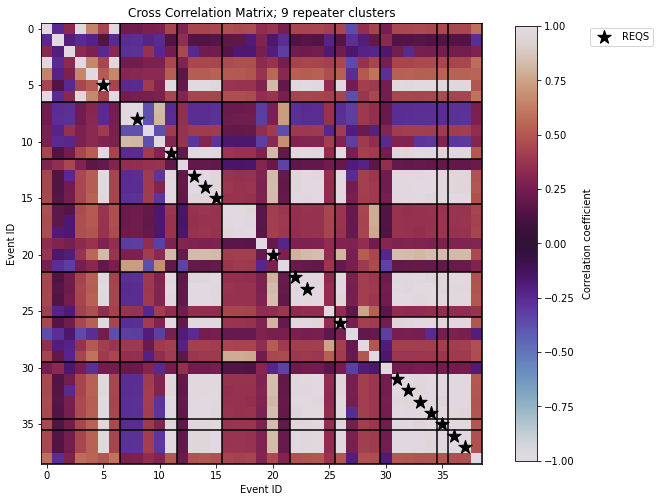

In [25]:
# plt.rcParams['image.cmap']='seismic'
plt.rcParams['image.cmap']='twilight'

plt.figure(figsize=(10,10))



plt.imshow(cc_mat)
cbar = plt.colorbar(pad=.06,shrink=.8)
cbar.set_label('Correlation coefficient',labelpad=8)#,fontsize = 14)

plt.clim(-1,1)

ax = plt.gca()
i=0
vv = 0

for i, clus in enumerate(list(repeater_clust)):
    
    clusCat = catAllClusAll.where(catAllClusAll.Cluster==clus).dropna()
    lenClus = len(clusCat)
    
    vv += lenClus
    
    plt.axvline(vv - .5,color='k')
    plt.axhline(vv - .5,color='k') 
    

ax = plt.gca()
ax.scatter(i,i,200,'k','*',label='REQS')
ax.legend(bbox_to_anchor=(1.4,1.))


for i, evID in enumerate(catAllClusAll.event_ID):
    
    if int(evID) in list(catRep.event_ID):## plot the actual, cataloged repeaters: 
        ax.scatter(i,i,200,'k','*',label='REQS')
        
#         if int(evID) ==list(catRep.event_ID)[0]:
#             print(i)
#             ax.legend(bbox_to_anchor=(1.45,1.))
# plt.legend({'Cluster'},bbox_to_anchor=(1.4,1.))    
plt.title(f'Cross Correlation Matrix; {Kopt} repeater clusters')
plt.xlabel('Event ID')
plt.ylabel('Event ID')

plt.savefig(f'figures/CC_k2000_K{Kopt}_k_k{NN}_twilight.png')


## Plot maps

In [31]:
cat_full = pd.read_csv(projectPath + 'data/processed/cat_specufex.csv')
cat_full['event_ID']

0           8391
1           8586
2           8863
3           9143
4          10109
          ...   
4279    73319996
4280    73321446
4281    73321526
4282    73321761
4283    73321901
Name: event_ID, Length: 4284, dtype: int64

In [ ]:
catAllClusAll

,timestamp,event_ID,lat,long,depth_km,year,month,day,hour,minute,...,timestamp.1,PC1,PC2,PC3,PC4,PC5,Cluster,SS,euc_dist,ev_ID_y
0,1984-11-07 08:21:42.030,31424,36.456361,-121.032824,5.358,1984,11,7,8,21,...,1984-11-07 08:21:42.030,-0.094347,-0.408705,0.144286,0.189969,0.074810,187,0.506117,24.480182,31424
1,1986-06-20 01:37:11.082,75019,36.456312,-121.032531,5.460,1986,6,20,1,37,...,1986-06-20 01:37:11.082,-0.511152,-0.438605,0.054564,-0.340947,0.279520,1682,0.106600,19.908981,75019
2,1988-02-20 03:59:05.270,112576,36.456469,-121.032534,5.243,1988,2,20,3,59,...,1988-02-20 03:59:05.270,-0.439537,-0.359281,0.134550,-0.257910,0.180053,1682,0.047937,19.689936,112576
3,1989-11-13 23:36:17.172,147374,36.456277,-121.032225,5.545,1989,11,13,23,36,...,1989-11-13 23:36:17.172,-0.481132,-0.132601,0.094467,-0.205538,0.045564,94,0.157488,19.411462,147374
4,1991-11-04 18:42:14.928,236562,36.456266,-121.032393,5.514,1991,11,4,18,42,...,1991-11-04 18:42:14.928,-0.359181,-0.445558,-0.040052,-0.266508,-0.024194,227,-0.024475,19.639477,236562
5,1993-07-21 20:51:48.070,368676,36.456385,-121.032499,5.523,1993,7,21,20,51,...,1993-07-21 20:51:48.070,-0.496855,-0.245485,0.129003,-0.170930,0.158408,94,0.048551,20.310799,368676
6,1997-01-12 18:30:30.143,490792,36.456278,-121.032505,5.555,1997,1,12,18,30,...,1997-01-12 18:30:30.143,-0.448634,-0.238539,0.036025,-0.155914,0.086171,1203,-0.012114,19.526231,490792
7,2001-01-04 14:16:34.287,21142181,36.456207,-121.032548,5.298,2001,1,4,14,16,...,2001-01-04 14:16:34.287,-0.473533,-0.128015,0.085703,-0.194744,0.082343,94,0.184276,19.361904,21142181
8,2003-02-28 01:09:02.640,21269282,36.456377,-121.032535,5.359,2003,2,28,1,9,...,2003-02-28 01:09:02.640,-0.470008,-0.304305,-0.047001,-0.269402,0.332401,542,0.035526,20.188960,21269282
9,2005-01-21 15:57:43.487,21434869,36.456656,-121.032791,5.508,2005,1,21,15,57,...,2005-01-21 15:57:43.487,-0.327181,-0.251771,-0.074960,-0.101921,0.098626,89,-0.007215,19.975669,21434869


In [110]:
cat_full = pd.read_csv(projectPath + 'data/processed/cat_specufex.csv')
cat_full.columns

##  convert evID to str
cat_full['event_ID'] = [str(int(evv)) for evv in cat_full['event_ID']]
catAllClusAll['event_ID'] = [str(int(evv)) for evv in catAllClusAll['event_ID']]
catRep['event_ID'] = [str(int(evv)) for evv in catRep['event_ID']]
## merge based on event ID
cat00 = pd.merge(cat_full,catAllClusAll,on='event_ID')
cat00_rep = pd.merge(cat_full,catRep,on='event_ID')

## convert to datetime, set as index
cat00['timestamp'] = [pd.to_datetime(i) for i in cat00.timestamp]
cat00['datetime_index']= [pd.to_datetime(i) for i in cat00.timestamp]
cat00 = cat00.set_index('datetime_index')

In [52]:
from figureFunctions2 import plotMapGMT

In [54]:
stat_df = pd.DataFrame({'lat':36.645954,
                        'long':-121.030151},
                      index=['BAV'])


TypeError: 'Figure' object is not subscriptable

In [104]:
np.unravel

AttributeError: module 'numpy' has no attribute 'unravel'

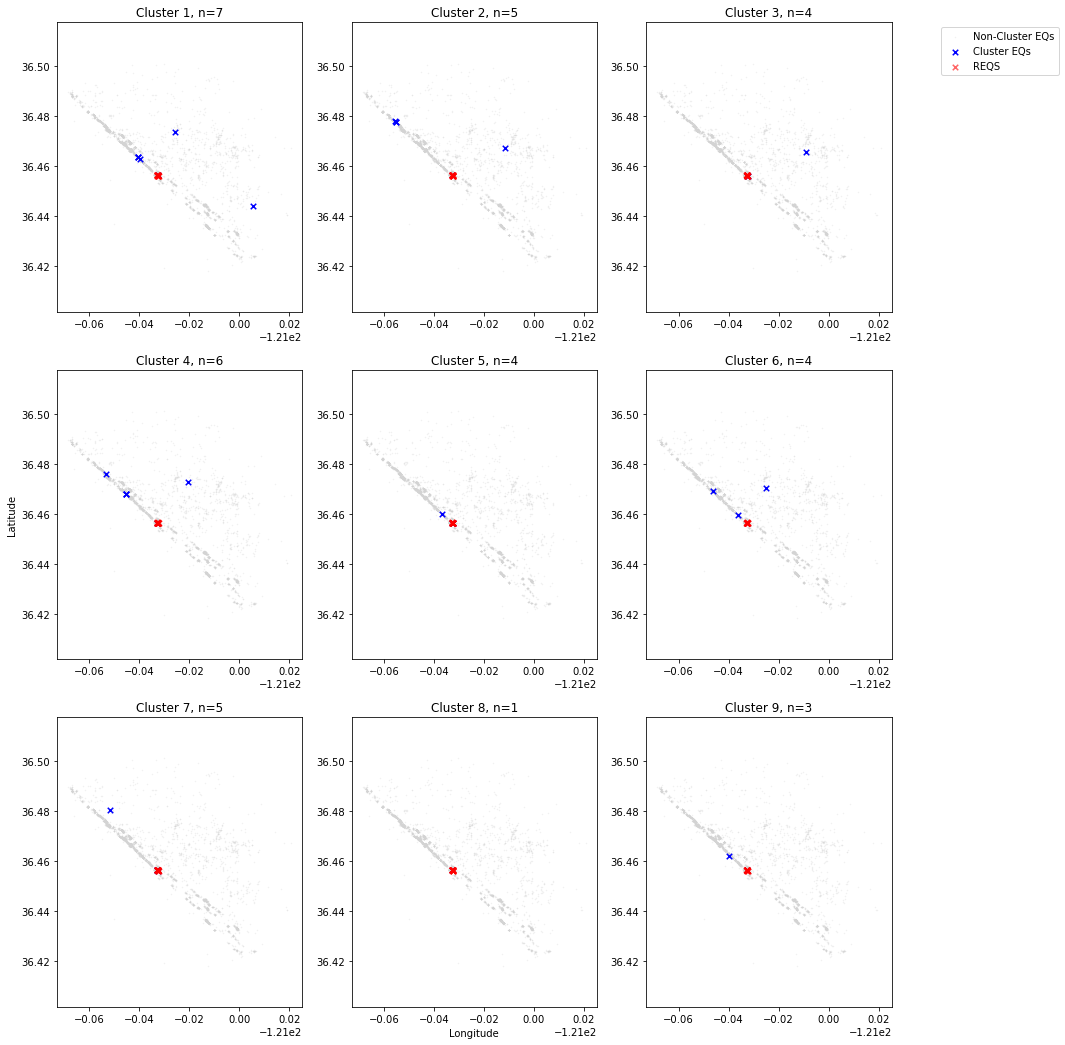

In [175]:

buff = 1

cat_feat = cat00 



fig, axes = plt.subplots(figsize=(width2*2,height2*2),ncols=3,nrows=3)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=.2)


s=30
for i, ax in enumerate(fig.axes):
    
    cluster = repeater_clust[i]
    
    cat000 = cat00.where(cat00.Cluster==cluster).dropna()
    
    
    ax.axis('equal')
    
    ax.scatter(
        x=cat_full.long,
        y=cat_full.lat,
        s=.3,
        c='lightgray',
        alpha=.3,
        marker='x',
        label='Non-Cluster EQs'
    )

    ax.scatter(
        x=cat000.long,
        y=cat000.lat,
        s=s,
        c='blue',
        alpha=1,
        marker='x',
        label='Cluster EQs'
    )
    
    ax.scatter(
        x=cat00_rep.long,
        y=cat00_rep.lat,
        s=s,
        c='red',
        alpha=.6,
        marker='x',
        label='REQS'
    )
    ax.set_title(f'Cluster {i+1}, n={len(cat000)}')
    
    if i==3:

        ax.set_ylabel('Latitude')    
    if i==7:
        ax.set_xlabel('Longitude')
        
        
        
# plt.suptitle('Map view of events',y=.92)
plt.legend(markerscale=1, bbox_to_anchor=(1.7,3.4))
plt.savefig(f'figures/map_repeaterClusters_k{NN}.png')



In [85]:
width1, width2


(3.74016, 7.48031)